In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import tqdm
import pickle
import time

import uncertainties as uct
from uncertainties import unumpy as unp


from swimAD2 import swimAD2 as ad2       # copy swimAD2.py to your working directory
import dwfconstants as dwfc

ad2.disconnect()            # close all instances before connecting
# zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

2.0 -9.215686274509803 1.627659574468085
8192 4096.0


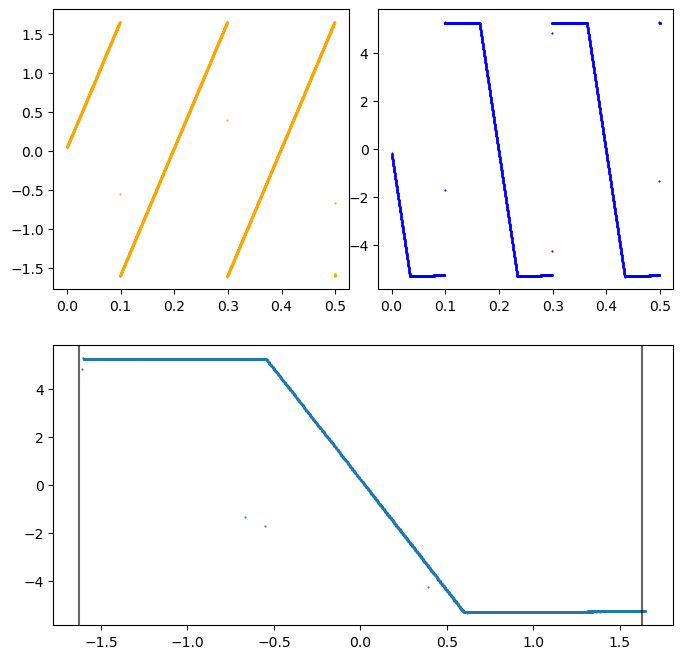

In [209]:
def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        print(size,hertz)
        return size,round(hertz)

def config_measurement(zoroku,freq,Vin=5.):
    ad2.config_wavegen(zoroku, 
                frequency=freq,
                amplitude=Vin, # Vin : Voltage range to observe.
                symmetry = 100,
                signal_shape= dwfc.funcTriangle
                )
    t_mes = 10/freq
    rate,size = sampling(t_mes)
    ad2.config_oscilloscope(zoroku,
        range0=23,
        range1=23,
        sample_rate = rate,
        sample_size = size
        )
    
########## End of Function Defining ##########

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

E_sat = 15
freq = 5
t_mes = 10/freq

R1 = 510
R2 = 4700
amp = -R2/R1
v_range = E_sat*R1/R2
print(t_mes,amp,v_range)

config_measurement(zoroku,freq,v_range)#,v_range)

ad2.start_wavegen(zoroku,channel=0)
time.sleep(0.2)
T,Ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
ad2.stop_wavegen(zoroku,channel=0)

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)
v_range = E_sat*R1/R2
axs3.axvline(x=v_range,color="black",alpha=0.6)
axs3.axvline(x=-v_range,color="black",alpha=0.6)

34.0
Data up to resistor 150 has been collected and saved.
23.181818181818183
Data up to resistor 220 has been collected and saved.
15.454545454545455
Data up to resistor 330 has been collected and saved.
10.851063829787234
Data up to resistor 470 has been collected and saved.
10.0
Data up to resistor 510 has been collected and saved.
6.375
Data up to resistor 800 has been collected and saved.
5.1
Data up to resistor 1000 has been collected and saved.
2.55
Data up to resistor 2000 has been collected and saved.
1.0851063829787233
Data up to resistor 4700 has been collected and saved.
0.51
Data up to resistor 10000 has been collected and saved.


C:\Users\chwan\AppData\Local\Temp\ipykernel_25236\614224826.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


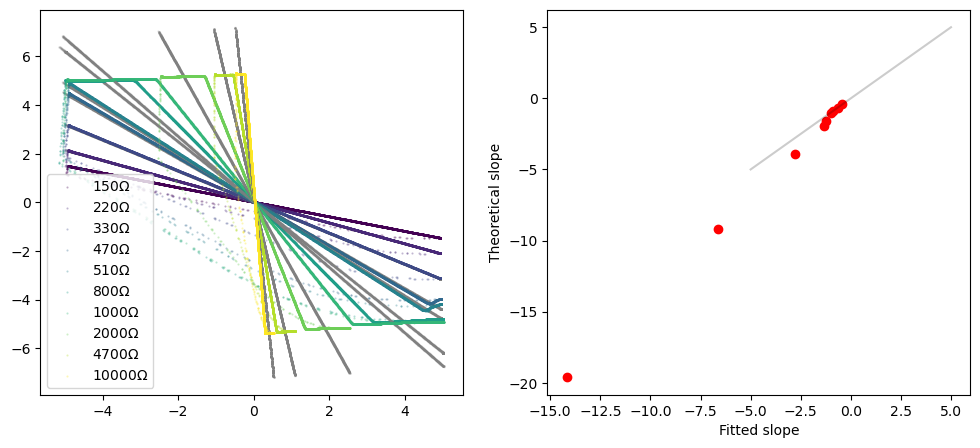

In [138]:
from scipy.optimize import curve_fit

def linear(x,a,b):
    return a*x+b

def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        return size,round(hertz)

def config_measurement(zoroku,t_mes,Vin=5.):
    ad2.config_wavegen(zoroku, 
                frequency=10/t_mes,
                amplitude=Vin, # Vin : Voltage range to observe.
                symmetry = 100,
                signal_shape= dwfc.funcTriangle
                )
    rate,size = sampling(t_mes)
    ad2.config_oscilloscope(zoroku,
        range0=23,
        range1=23,
        sample_rate = rate,
        sample_size= size,
        )
    
########## End of Function Defining ##########

R1 =  510 # in Ohms
Res2 = [150,220,330,470,510,800,1000,2000,4700,10000]
data_dict = {"R1": R1,"R2":Res2}

for R2 in data_dict["R2"]: 
    data_dict[R2] = "NaN"

E_sat = 5 # Bias voltage
t_mes = 0.1 # Measurement time

fig = plt.figure(figsize=(12,5))
grid = gs.GridSpec(1,2,wspace=0.2)
axs1 = plt.subplot(grid[0])
axs2 = plt.subplot(grid[1])

colors = plt.cm.viridis(np.linspace(0, 1, len(Res2)))

m_values = []
for i,R2 in enumerate(data_dict["R2"]): 
    v_range = E_sat*R1/R2
    print(v_range)
    config_measurement(zoroku,0.1,v_range)
    
    ad2.start_wavegen(zoroku,channel=0)
    time.sleep(0.1)
    T,Ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
    ad2.stop_wavegen(zoroku,channel=0)
    
    data_dict[R2] = T,Ch1,Ch2
    
    handle = open("inverting_amp.pkl", 'wb')
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

    popt,_ = curve_fit(linear,Ch1,Ch2,p0=[-R2/R1,25e-6])
    X = np.linspace(-v_range,v_range)

    axs1.scatter(Ch1,linear(Ch1,popt[0],popt[1]),s=0.5,alpha=0.1,color="grey")
    axs1.scatter(Ch1,Ch2,label=fr"{R2}$\Omega$",s=0.3,alpha=0.3,color=colors[i])
    m_values.append(popt[0])

    print("Data up to resistor %d has been collected and saved." % R2)
    input("Switch resistor, then press ENTER to measure.")

axs1.legend(loc="lower left")

m_theory = [-R2/R1 for R2 in Res2]
axs2.scatter(m_values[1:],m_theory[1:],color="red")

X = np.linspace(-5,0)
axs2.plot(X,X,color="black",alpha=0.2)

axs2.set_ylabel("Theoretical slope")
axs2.set_xlabel("Fitted slope")
fig.show()

c:\ProgramData\anaconda3\envs\yeerum\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-0.29938357  0.0181863   1.          1.        ]
[-0.42796633  0.01757195  1.          1.        ]
[-0.63846743  0.0148932   1.          1.        ]
[-0.89108156  0.02925056  1.          1.        ]
[-0.96937022  0.04059007  1.          1.        ]
[-1.68589963e+00  3.82695550e-02  1.90000000e+03  1.90000000e+03]
[-1.86001887e+00  3.63514884e-02  1.90000000e+03  1.90000000e+03]
[-3.82942099e+00  7.22998710e-02  1.90000000e+03  1.90000000e+03]
[-9.12642470e+00  1.96031634e-01  1.90000000e+03  1.90000000e+03]
[-1.95323856e+01  4.69273807e-01  1.90000000e+03  1.90000000e+03]


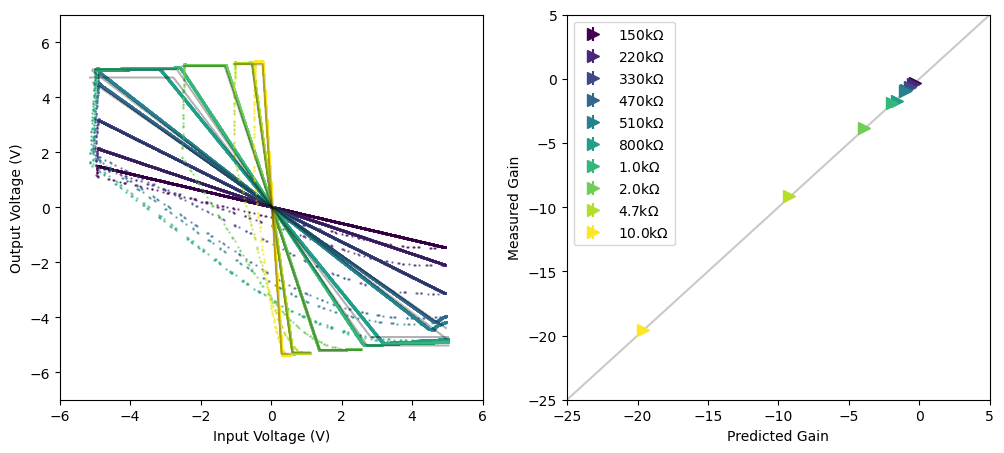

In [53]:
# Data analysis (perform on already collected pkl.)
from scipy.optimize import curve_fit

def linear(x,a,b):
    return a*x+b

def fit(x,a,b,reg1,reg2):
    reg1,reg2 = int(reg1),int(reg2)
    V1 = linear(x[reg1],a,b)
    y1 = np.full(reg1,V1)
    y2 = linear(x[reg1:-reg2],a,b)
    V2 = linear(x[-reg2],a,b)
    y3 = np.full(reg2,V2)
    y = np.concatenate((y1,y2,y3))
    return y

########## End of Function Defining ##########

fig = plt.figure(figsize=(12,5))
grid = gs.GridSpec(1,2)
axs1 = plt.subplot(grid[0])
axs2 = plt.subplot(grid[1])

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

R1 = data["R1"]
Res2 = data["R2"]
E_sat = 6

colours = plt.cm.viridis(np.linspace(0, 1, len(Res2)))

X = np.linspace(-30,10)
axs2.plot(X,X,color="black",alpha=0.01)

m_values = []
for i, R2 in enumerate(Res2):
    t,Vin,Vout = data[R2]
    
    # Vin = Vin[:200]
    # Vout = Vout[:200]
    # Sort time series by increasing Ch1 values. 
    indices = np.argsort(Vin) 
    Vin = Vin[indices]
    Vout = Vout[indices]

    E_sat = 6
    amp = -R2/R1
    trial = [amp,25e-6,1,1]
    if R2 >= 800:
        trial = [amp,25e-6,1900,1900]
    popt,pcov = curve_fit(fit,Vin,Vout,p0=trial,maxfev = 10800)
    print(popt)
    perr = np.sqrt(np.diag(pcov))
    m = -R2/R1
    axs1.plot(Vin,fit(Vin,*popt),color="black",alpha=0.3)
    if R2 >= 1000: 
        R2 /= 1000
        label = fr"{R2}k$\Omega$"
    else: label = fr"{R2}$\Omega$"
    axs1.scatter(Vin,Vout
                 ,s=0.5,alpha=0.6,color=colours[i]
                 )
    
    axs2.errorbar(m,popt[0]
                  ,label=fr"{R2}k$\Omega$"
                  ,yerr = perr[0]
                  ,fmt=">",markersize="9",color = colours[i]
                  )
axs2.legend(loc="upper left")
axs1.set_ylim(-7,7)
axs1.set_xlim(-6,6)
axs1.set_ylabel("Output Voltage (V)")
axs1.set_xlabel("Input Voltage (V)")

axs2.set_ylim(-25,5)
axs2.set_xlim(-25,5)
axs2.plot(X,X,color="black",alpha=0.2)
axs2.set_ylabel(r"Measured Gain")
axs2.set_xlabel(r"Predicted Gain")

fig.savefig("figures/inverting_slops.png")

[-19.26547388   0.48383681  18.          21.        ] -19.607843137254903


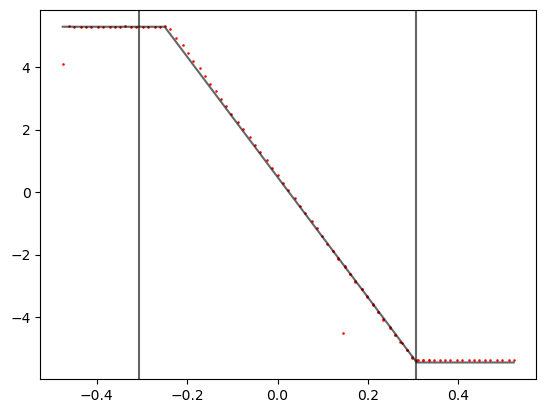

In [13]:
# A more precise fitting method. 

def linear(x,a,b):
    return a*x+b

def fit(x,a,b,reg1,reg2):
    reg1,reg2 = int(reg1),int(reg2)
    V1 = linear(x[reg1],a,b)
    y1 = np.full(reg1,V1)
    y2 = linear(x[reg1:-reg2],a,b)
    V2 = linear(x[-reg2],a,b)
    y3 = np.full(reg2,V2)
    y = np.concatenate((y1,y2,y3))
    return y
    
########## End of Function Defining ##########

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

R1 = data["R1"]
Res2 = data["R2"]
R2 = Res2[9]

T, Ch1, Ch2 = data[R2]

# Select a single cycle. 
Ch1 = Ch1[:100]
Ch2 = Ch2[:100]

# Sort time series by increasing Ch1 values. 
indices = np.argsort(Ch1) 
Ch1 = Ch1[indices]
Ch2 = Ch2[indices]

E_sat = 6
amp = -R2/R1

popt,_ = curve_fit(fit,Ch1,Ch2,p0=[amp,25e-6,18,21],maxfev = 2800)
plt.plot(Ch1,fit(Ch1,*popt),color="black",alpha=0.6)
print(popt,amp)
plt.scatter(Ch1,Ch2,s=0.7,color="red")

v_range = E_sat*R1/R2
plt.axvline(x=v_range,color="black",alpha=0.6)
plt.axvline(x=-v_range,color="black",alpha=0.6)
plt.show()

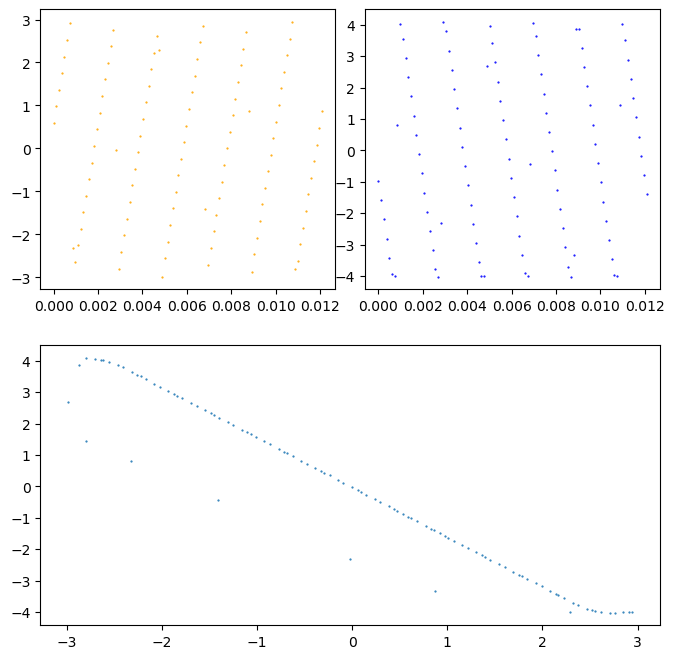

In [4]:
# Transfer curve by frequencies

handle = open("inverting_amp_high.pkl", 'rb')
data_h=pickle.load(handle)
handle.close()

handle = open("inverting_amp_low.pkl", 'rb')
data_l=pickle.load(handle)
handle.close()

R1 = data_l["R1"]
freq = data_l["Freq"]
f = freq[6]

T, Ch1, Ch2 = data_l[f]
length = 100
T = T[:length]
Ch1 = Ch1[:length]
Ch2 = Ch2[:length]

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)
